# Test binarizer models

This notebook tests pre-trained NAFNet binarizing denoisers, which were trained on a subset of ShabbyPages and the full NoisyOffice set respectively.

The models are loaded and used to denoise a validation set taken from ShabbyPages and the NoisyOfficeReal validation images.

In [ ]:
!git clone https://github.com/kwcckw/NAFNet

Cloning into 'NAFNet'...
remote: Enumerating objects: 633, done.
remote: Counting objects: 100% (277/277), done.
remote: Compressing objects: 100% (121/121), done.
remote: Total 633 (delta 203), reused 199 (delta 151), pack-reused 356
Receiving objects: 100% (633/633), 16.21 MiB | 18.34 MiB/s, done.
Resolving deltas: 100% (334/334), done.


# Copying Models

We first make a folder in the container and copy the pre-trained model weights from Google Drive into there.

In [ ]:
# connect to gdrive
from google.colab import drive
drive.mount('/content/drive')

# create folder
! mkdir NAFNet/experiments

# copy to experiments folder
! cp -r /content/drive/'My Drive'/ICDAR_models/NAFNet/model_weights_noisyoffice-BW/noisyoffice_x64 /content/NAFNet/experiments
! cp -r /content/drive/'My Drive'/ICDAR_models/NAFNet/model_weights_shabby-BW/shabby_x64 /content/NAFNet/experiments

Mounted at /content/drive


# Environment Setup
Now we add our dependencies.

In [ ]:
! pip install -r NAFNet/requirements.txt
%cd /content/NAFNet
! python setup.py develop --no_cuda_ext
%cd /content

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.6/5.6 MB 83.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 190.2/190.2 KB 23.5 MB/s eta 0:00:00
/content/NAFNet
running develop
running egg_info
creating basicsr.egg-info
writing basicsr.egg-info/PKG-INFO
writing dependency_links to basicsr.egg-info/dependency_links.txt
writing top-level names to basicsr.egg-info/top_level.txt
writing manifest file 'basicsr.egg-info/SOURCES.txt'
adding license file 'LICENSE'
writing manifest file 'basicsr.egg-info/SOURCES.txt'
/usr/local/lib/python3.8/dist-packages/torch/utils/cpp_extension.py:476: UserWarning: Attempted to use ninja as the BuildExtension backend but we could not find ninja.. Falling back to using the slow distutils backend.
  warnings.warn(msg.format('we could not find ninja.'))
running build_ext
Creating /usr/local/lib/python3.8/dist-packages/basicsr.egg-link (link to .)
Ad

# Getting the Data
Here we download our testing data.

In [ ]:
! git clone https://github.com/kwcckw/DenoisingShabbyPagesData
! git clone https://github.com/kwcckw/Converted_noisy_office

Cloning into 'DenoisingShabbyPagesData'...
remote: Enumerating objects: 3234, done.
remote: Counting objects: 100% (4/4), done.
remote: Compressing objects: 100% (4/4), done.
remote: Total 3234 (delta 0), reused 4 (delta 0), pack-reused 3230
Receiving objects: 100% (3234/3234), 207.20 MiB | 16.14 MiB/s, done.
Resolving deltas: 100% (3/3), done.
Cloning into 'Converted_noisy_office'...
remote: Enumerating objects: 306, done.
remote: Counting objects: 100% (22/22), done.
remote: Compressing objects: 100% (18/18), done.
remote: Total 306 (delta 3), reused 16 (delta 1), pack-reused 284
Receiving objects: 100% (306/306), 80.87 MiB | 13.15 MiB/s, done.
Resolving deltas: 100% (4/4), done.
Updating files: 100% (435/435), done.


# File Setup
We make directories and copy our data to them.

In [ ]:
# clean test directories
! mkdir -p /content/NAFNet/datasets/shabby/test/clean
! mkdir -p /content/NAFNet/datasets/noisyoffice/test/clean
! cp /content/DenoisingShabbyPagesData/test/test/test_cleaned/* /content/NAFNet/datasets/shabby/test/clean
! cp /content/Converted_noisy_office/test/test/test_cleaned/* /content/NAFNet/datasets/noisyoffice/test/clean

# noisy test directories
! mkdir -p /content/NAFNet/datasets/shabby/test/noisy
! mkdir -p /content/NAFNet/datasets/noisyoffice/test/noisy
! cp /content/DenoisingShabbyPagesData/test/test/test_shabby/* /content/NAFNet/datasets/shabby/test/noisy
! cp /content/Converted_noisy_office/test/test/test_noisy/* /content/NAFNet/datasets/noisyoffice/test/noisy

# prediction results directories
! mkdir -p /content/NAFNet/datasets/shabby/test/clean_predicted_shabby_NAFNet
! mkdir -p /content/NAFNet/datasets/shabby/test/clean_predicted_noisy_NAFNet
! mkdir -p /content/NAFNet/datasets/noisyoffice/test/clean_predicted_shabby_NAFNet
! mkdir -p /content/NAFNet/datasets/noisyoffice/test/clean_predicted_noisy_NAFNet

The models we're testing were trained on binarized groundtruth images; here we Otsu binarize the groundtruth images accordingly. We define a function to do this, then parallelize its application across a process pool.

In [ ]:
from pathlib import Path
import cv2
import os
from multiprocessing import Pool
import numpy as np

# # A utility function for preprocessing
# def grayscale(image_path: Path):
#     # read the images in as f32 arrays, for increased precision
#     img = cv2.imread(image_path.as_posix()).astype(np.float32)

#     # grayscale image
#     img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

#     # normalize pixel intensity values to the 8-bit range (still f32)
#     img = img / 255.0

#     return img.astype(np.uint8)

# def binarize_groundtruths(filename: Path):
#   clean = grayscale(filename)
#   out, binary = cv2.threshold(clean,0,255,cv2.THRESH_BINARY + cv2.THRESH_OTSU)
#   cv2.imwrite(filename.as_posix(), binary)


In [ ]:
from pathlib import Path
import cv2
import os
from multiprocessing import Pool
import numpy as np
import os
import matplotlib
import matplotlib.pyplot as plt
from skimage.filters import (threshold_otsu, threshold_niblack, threshold_sauvola)
from skimage import io
from skimage.color import rgb2gray
from google.colab.patches import cv2_imshow

WS_NIBLACK = 25
WS_SAUVOLA = 25

def niblack(img, window_size=WS_NIBLACK, k=0.8):
  th = threshold_niblack(img, window_size, k)
  bin_img = img > th
  return bin_img

def sauvola(img, window_size=WS_SAUVOLA):
  th = threshold_sauvola(img, window_size)
  bin_img = img > th
  return bin_img

def otsu(img):
  bin_img = img > threshold_otsu(img)
  return bin_img

def ensemble_average_binarize(img):
  a = niblack(img) * 1.0
  b = sauvola(img) * 1.0
  c = otsu(img) * 1.0
  m = (a + b + c) / 3
  return m > 0.5

def binarize_groundtruths(filename: Path):
  # read the images in as f32 arrays, for increased precision
  img = rgb2gray(io.imread(filename.as_posix()))
  print(img.dtype)
  binarized = ensemble_average_binarize(img).astype(np.float32)
  io.imsave(filename.as_posix(), binarized)

In [ ]:
noisyoffice_clean_path = Path('/content/NAFNet/datasets/noisyoffice/test/clean/')
shabby_clean_path = Path('/content/NAFNet/datasets/shabby/test/clean/')
noisyoffice_clean_list = [f for f in noisyoffice_clean_path.iterdir()]
shabby_clean_list = [f for f in shabby_clean_path.iterdir()]

pool = Pool(os.cpu_count())
pool.map(binarize_groundtruths, noisyoffice_clean_list)
pool.map(binarize_groundtruths, shabby_clean_list)

float64float64float64
float64float64float64
float64


float64

float64

float64float64float64




float64
float64
float64
float64
float64float64

float64float64float64

float64
float64

float64


float64

float64float64

float64

float64float64
float64


float64
float64
float64

float64



float64

float64float64



float64
float64
float64

float64


float64
float64float64float64


float64


float64


float64
float64float64

float64

float64

float64
float64


float64


<ipython-input-7-5c07732a3ae9>:40: FutureWarning: The behavior of rgb2gray will change in scikit-image 0.19. Currently, rgb2gray allows 2D grayscale image to be passed as inputs and leaves them unmodified as outputs. Starting from version 0.19, 2D arrays will be treated as 1D images with 3 channels.
  img = rgb2gray(io.imread(filename.as_posix()))
<ipython-input-7-5c07732a3ae9>:40: FutureWarning: The behavior of rgb2gray will change in scikit-image 0.19. Currently, rgb2gray allows 2D grayscale image to be passed as inputs and leaves them unmodified as outputs. Starting from version 0.19, 2D arrays will be treated as 1D images with 3 channels.
  img = rgb2gray(io.imread(filename.as_posix()))
<ipython-input-7-5c07732a3ae9>:40: FutureWarning: The behavior of rgb2gray will change in scikit-image 0.19. Currently, rgb2gray allows 2D grayscale image to be passed as inputs and leaves them unmodified as outputs. Starting from version 0.19, 2D arrays will be treated as 1D images with 3 channels.

uint8uint8

<ipython-input-7-5c07732a3ae9>:40: FutureWarning: The behavior of rgb2gray will change in scikit-image 0.19. Currently, rgb2gray allows 2D grayscale image to be passed as inputs and leaves them unmodified as outputs. Starting from version 0.19, 2D arrays will be treated as 1D images with 3 channels.
  img = rgb2gray(io.imread(filename.as_posix()))


uint8uint8uint8uint8uint8uint8uint8
uint8





<ipython-input-7-5c07732a3ae9>:40: FutureWarning: The behavior of rgb2gray will change in scikit-image 0.19. Currently, rgb2gray allows 2D grayscale image to be passed as inputs and leaves them unmodified as outputs. Starting from version 0.19, 2D arrays will be treated as 1D images with 3 channels.
  img = rgb2gray(io.imread(filename.as_posix()))






uint8

uint8


uint8uint8


uint8

uint8uint8
uint8uint8



uint8uint8

uint8



uint8

uint8



uint8uint8uint8uint8


uint8

uint8uint8



uint8



uint8uint8


uint8

uint8uint8uint8


uint8



uint8

uint8uint8



uint8uint8


uint8uint8


uint8



uint8


uint8


uint8



uint8


uint8

uint8

uint8

uint8uint8


uint8uint8
uint8
uint8

uint8

uint8uint8





uint8

uint8


uint8


uint8uint8
uint8

uint8uint8uint8


uint8


uint8


uint8

uint8uint8




uint8
uint8

uint8uint8



uint8

uint8uint8



uint8uint8



uint8uint8
uint8




uint8uint8


uint8uint8
uint8



uint8

uint8

uint8


uint8uint8



uint8uint8



uint8uint8uint8



uint8


uint8

uint8

uint8uint8uint8




uint8


uint8

uint8


uint8
uint8
uint8

uint8
uint8
uint8



uint8


uint8
uint8

uint8
uint8


uint8


uint8


uint8


uint8


uint8


uint8uint8


uint8uint8

uint8
uint8uint8


uint8uint8uint8uint8





uint8

uint8uint8

uint8
uint8uint8


uint8


uint8uint8


uint8
uint8


uint8uint8



uint8

uint8



uint8

uint8uint8

uint8



uint8

uint8


uint8uint8


uint8




uint8

uint8
uint8

uint8



uint8
uint8
uint8


uint8uint8



uint8

uint8
uint8uint8


uint8


uint8uint8
uint8



uint8
uint8


uint8
uint8


uint8


[None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,

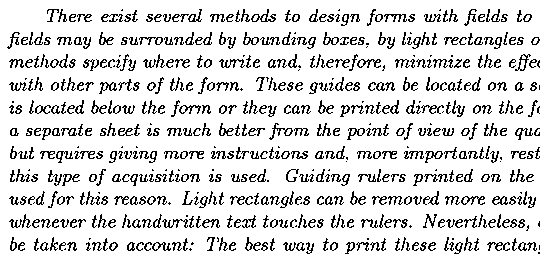

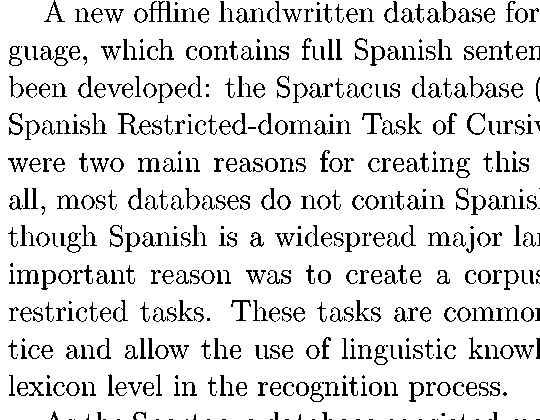

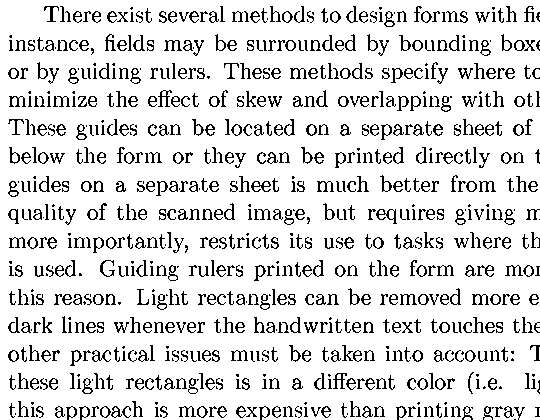

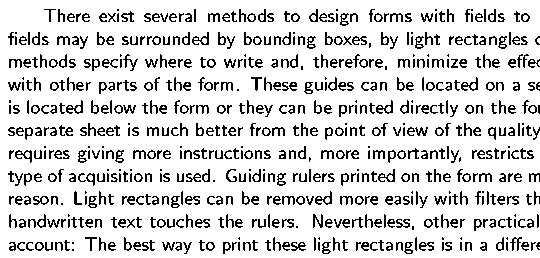

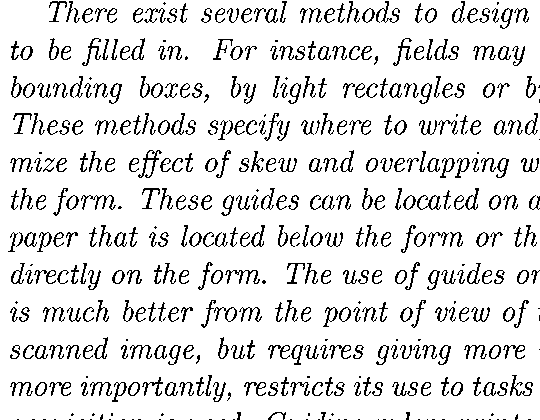

In [ ]:
from google.colab.patches import cv2_imshow
import cv2
from pathlib import Path
import random
import os

imgpath = Path('/content/Converted_noisy_office/test/test/test_cleaned/')
imgfiles = random.sample(os.listdir(imgpath), 5)

for imgfile in imgfiles:
  img = cv2.imread((noisyoffice_clean_path / imgfile).as_posix())
  cv2_imshow(img)

In [ ]:
# try:
#   break
# except:
#   break

# Importing the Models

Now we finally import all the rest of our dependencies and import our models.

In [ ]:
%cd NAFNet

/content/NAFNet


In [ ]:
import torch

from basicsr.models import create_model
from basicsr.utils import img2tensor as _img2tensor, tensor2img, imwrite
from basicsr.utils.options import parse
import numpy as np
import cv2
import matplotlib.pyplot as plt
from glob import glob
import os
from tqdm import tqdm

In [ ]:
# functions

def imread(img_path):
  img = cv2.imread(img_path)
  img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
  return img

def img2tensor(img, bgr2rgb=False, float32=True):
    img = img.astype(np.float32) / 255.
    return _img2tensor(img, bgr2rgb=bgr2rgb, float32=float32)


def single_image_inference(model, img, save_path):
    model.feed_data(data={'lq': img.unsqueeze(dim=0)})
    
    if model.opt['val'].get('grids', False):
        model.grids()
    
    model.test()
    
    if model.opt['val'].get('grids', False):
        model.grids_inverse()
    
    visuals = model.get_current_visuals()
    sr_img = tensor2img([visuals['result']])
    # imwrite(sr_img, save_path)

    return sr_img

In [ ]:
# Load trained models

def pretrained_NAFNet(filepath):
  opt = parse(filepath, is_train=False)
  opt['dist'] = False
  return create_model(opt)


shabby_NAFNet = pretrained_NAFNet('options/test/SHABBY/shabby_x64.yml')
noisy_NAFNet = pretrained_NAFNet('options/test/SHABBY/noisyoffice_x64.yml')

 load net keys <built-in method keys of collections.OrderedDict object at 0x7f4af2738540>
 load net keys <built-in method keys of collections.OrderedDict object at 0x7f4af2612b40>


# Make Predictions
With our models trained, we make our predictions on each validation set, writing these out to disk. For convenience, we define a utility function to do this, parametrized over models, the path to the relevant ground truths, and the output path for saved predictions.

In [ ]:
from cv2 import imread
from pathlib import Path

def make_and_save_predictions(model, input_path_str, output_path_str):
  input_path = Path(input_path_str)
  output_path = Path(output_path_str)
  input_image_filenames = [(input_path / filename) for filename in os.listdir(input_path)]
  for image_filename in tqdm(input_image_filenames):
    input_image = imread(image_filename.as_posix())
    input_tensor = img2tensor(input_image)
    output_image = single_image_inference(model, input_tensor, output_path_str)
    output_filepath = output_path_str + image_filename.name
    cv2.imwrite(output_filepath, output_image)

In [ ]:
noisyoffice_clean_inputs = '/content/NAFNet/datasets/noisyoffice/test/clean'
shabby_clean_inputs = '/content/NAFNet/datasets/shabby/test/clean'

noisyoffice_test_inputs = '/content/NAFNet/datasets/noisyoffice/test/noisy/'
shabby_test_inputs = '/content/NAFNet/datasets/shabby/test/noisy/'

# Shabby_NAFNet predicting NoisyOffice images
noisyoffice_clean_predicted_shabby_NAFNet = '/content/NAFNet/datasets/noisyoffice/test/clean_predicted_shabby_NAFNet/'
make_and_save_predictions(shabby_NAFNet, noisyoffice_test_inputs, noisyoffice_clean_predicted_shabby_NAFNet)

# Shabby_NAFNet predicting Shabby images
shabby_clean_predicted_shabby_NAFNet = '/content/NAFNet/datasets/shabby/test/clean_predicted_shabby_NAFNet/'
make_and_save_predictions(shabby_NAFNet, shabby_test_inputs, shabby_clean_predicted_shabby_NAFNet)

# Noisy_NAFNet predicting NoisyOffice images
noisyoffice_clean_predicted_noisy_NAFNet = '/content/NAFNet/datasets/noisyoffice/test/clean_predicted_noisy_NAFNet/'
make_and_save_predictions(noisy_NAFNet, noisyoffice_test_inputs, noisyoffice_clean_predicted_noisy_NAFNet)

# Noisy_NAFNet predicting Shabby images
shabby_clean_predicted_noisy_NAFNet = '/content/NAFNet/datasets/shabby/test/clean_predicted_noisy_NAFNet/'
make_and_save_predictions(noisy_NAFNet, shabby_test_inputs, shabby_clean_predicted_noisy_NAFNet)

100%|██████████| 186/186 [00:12<00:00, 14.58it/s]


# Displaying Predictions

Let's take a look at the predictions, together with the image they denoised and the ground truth target. As usual, we define a utility function to render these, parametrized over the paths to the test, clean, and predicted images, as well as the title of the rendered plot.

In [ ]:
from glob import glob
from matplotlib import pyplot as plt
import cv2
import random

def render_predictions(plot_title, tests_path, cleans_path, predictions_path):
  test_image_paths = glob(tests_path+'/*.png')
  clean_image_paths = glob(cleans_path+'/*.png')
  predicted_image_paths = glob(predictions_path+'/*.png')

  plt.rcParams['figure.figsize'] = [20, 10]
  plt.rcParams['figure.dpi'] = 300

  # Check the first 4 images
  indices = range(4)

  # Create a figure with 3 columns and 4 rows
  fig, axes = plt.subplots(4, 3, figsize=(10, 10))

  # Plot the images at the chosen indices
  for i, index in enumerate(indices):
      # Read the images in grayscale
      test_image = cv2.imread(test_image_paths[index], cv2.IMREAD_GRAYSCALE)
      clean_image = cv2.imread(clean_image_paths[index], cv2.IMREAD_GRAYSCALE)
      predicted_image = cv2.imread(predicted_image_paths[index], cv2.IMREAD_GRAYSCALE)

      # Plot the images in the corresponding subplots
      axes[i, 0].imshow(test_image, cmap='gray')
      axes[i, 1].imshow(clean_image, cmap='gray')
      axes[i, 2].imshow(predicted_image, cmap='gray')

  # Add a title to the figure
  fig.suptitle(plot_title)

  # Show the plot
  plt.show()

### Shabby_NAFNet predicting NoisyOffice images

In [ ]:
render_predictions('Shabby_NAFNet predicting NoisyOffice images',
                    noisyoffice_clean_inputs,
                    noisyoffice_test_inputs,
                    noisyoffice_clean_predicted_shabby_NAFNet)

### Shabby_NAFNet predicting Shabby images

In [ ]:
render_predictions('Shabby_NAFNet predicting Shabby images',
                    shabby_clean_inputs,
                    shabby_test_inputs,
                    shabby_clean_predicted_shabby_NAFNet)

### Noisy_NAFNet predicting NoisyOffice images

In [ ]:
render_predictions('Noisy_NAFNet predicting NoisyOffice images',
                    noisyoffice_clean_inputs,
                    noisyoffice_test_inputs,
                    noisyoffice_clean_predicted_noisy_NAFNet)

### Noisy_NAFNet predicting Shabby images

In [ ]:
render_predictions('Noisy_NAFNet predicting Shabby images',
                    shabby_clean_inputs,
                    shabby_test_inputs,
                    shabby_clean_predicted_noisy_NAFNet)

# Compute Metrics

Now we convert the images to grayscale and compute the SSIM between predictions and ground truths. As always, we define a utility function to compute the mean metric given that metric and paths to clean and predicted images.

In [ ]:
from skimage.metrics import structural_similarity
import numpy as np

# Adapted from https://dsp.stackexchange.com/questions/38065/peak-signal-to-noise-ratio-psnr-in-python-for-an-image
def compute_psnr(img1, img2, max_value=255):
    # best value = 100 (higher the better)
    mse = np.mean((img1 - img2) ** 2)
    if mse == 0:
        return 100
    else:
        return 20 * np.log10(max_value / np.sqrt(mse))


def compute_ssim(img1, img2):
  # best value = 1 (higher the better)
  return structural_similarity(img1, img2)


def compute_rmse(img1, img2):
    # best value = 0 (lower the better)
    squared_difference = (img1 - img2) ** 2
    summed_squared_difference = np.sum(squared_difference)
    total_pixels = img1.shape[0] * img1.shape[1]
    rmse = np.sqrt(summed_squared_difference / total_pixels)
    return rmse

def compute_average_metric(metric, cleans_path, predictions_path):
  metrics = []

  cleans_filenames = glob(cleans_path + "/*.png")
  predictions_filenames = glob(predictions_path + "/*.png")

  for (clean_path, predicted_path) in zip(cleans_filenames, predictions_filenames):
    img_clean = cv2.imread(clean_path, cv2.IMREAD_GRAYSCALE)
    img_predicted = cv2.imread(predicted_path, cv2.IMREAD_GRAYSCALE)

    metrics.append(metric(img_clean, img_predicted))
  
  average_metric = np.sum(metrics) / len(metrics)
  return average_metric


In [ ]:
# Shabby_NAFNet predicting Noisy images
shabbynet_noisy_ssims = compute_average_metric(compute_ssim, noisyoffice_clean_inputs, noisyoffice_clean_predicted_shabby_NAFNet)
shabbynet_noisy_rmses = compute_average_metric(compute_rmse, noisyoffice_clean_inputs, noisyoffice_clean_predicted_shabby_NAFNet)
shabbynet_noisy_psnrs = compute_average_metric(compute_psnr, noisyoffice_clean_inputs, noisyoffice_clean_predicted_shabby_NAFNet)
# Shabby_NAFNet predicting Shabby images
shabbynet_shabby_ssims = compute_average_metric(compute_ssim, shabby_clean_inputs, shabby_clean_predicted_shabby_NAFNet)
shabbynet_shabby_rmses = compute_average_metric(compute_rmse, shabby_clean_inputs, shabby_clean_predicted_shabby_NAFNet)
shabbynet_shabby_psnrs = compute_average_metric(compute_psnr, shabby_clean_inputs, shabby_clean_predicted_shabby_NAFNet)
# Noisy_NAFNet predicting Noisy images
noisynet_noisy_ssims = compute_average_metric(compute_ssim, noisyoffice_clean_inputs, noisyoffice_clean_predicted_noisy_NAFNet)
noisynet_noisy_rmses = compute_average_metric(compute_rmse, noisyoffice_clean_inputs, noisyoffice_clean_predicted_noisy_NAFNet)
noisynet_noisy_psnrs = compute_average_metric(compute_psnr, noisyoffice_clean_inputs, noisyoffice_clean_predicted_noisy_NAFNet)
# Noisy_NAFNet predicting Shabby images
noisynet_shabby_ssims = compute_average_metric(compute_ssim, shabby_clean_inputs, shabby_clean_predicted_noisy_NAFNet)
noisynet_shabby_rmses = compute_average_metric(compute_rmse, shabby_clean_inputs, shabby_clean_predicted_noisy_NAFNet)
noisynet_shabby_psnrs = compute_average_metric(compute_psnr, shabby_clean_inputs, shabby_clean_predicted_noisy_NAFNet)

print(f'Shabby_NAFNet predicting Noisy images average SSIM: {shabbynet_noisy_ssims}')
print(f'Shabby_NAFNet predicting Noisy images average RMSE: {shabbynet_noisy_rmses}')
print(f'Shabby_NAFNet predicting Noisy images average PSNR: {shabbynet_noisy_psnrs}')

print(f'Shabby_NAFNet predicting Shabby images average SSIM: {shabbynet_shabby_ssims}')
print(f'Shabby_NAFNet predicting Shabby images average RMSE: {shabbynet_shabby_rmses}')
print(f'Shabby_NAFNet predicting Shabby images average PSNR: {shabbynet_shabby_psnrs}')

print(f'Noisy_NAFNet predicting Noisy images average SSIM: {noisynet_noisy_ssims}')
print(f'Noisy_NAFNet predicting Noisy images average RMSE: {noisynet_noisy_rmses}')
print(f'Noisy_NAFNet predicting Noisy images average PSNR: {noisynet_noisy_psnrs}')

print(f'Noisy_NAFNet predicting Shabby images average SSIM: {noisynet_shabby_ssims}')
print(f'Noisy_NAFNet predicting Shabby images average RMSE: {noisynet_shabby_rmses}')
print(f'Noisy_NAFNet predicting Shabby images average PSNR: {noisynet_shabby_psnrs}')

Shabby_NAFNet predicting Noisy images average SSIM: 0.9465069385860134
Shabby_NAFNet predicting Noisy images average RMSE: 3.2046770685272117
Shabby_NAFNet predicting Noisy images average PSNR: 38.097843772060855
Shabby_NAFNet predicting Shabby images average SSIM: 0.9255905809319086
Shabby_NAFNet predicting Shabby images average RMSE: 2.987994328426575
Shabby_NAFNet predicting Shabby images average PSNR: 39.29266235129017
Noisy_NAFNet predicting Noisy images average SSIM: 0.9866020337197627
Noisy_NAFNet predicting Noisy images average RMSE: 3.8045857559449296
Noisy_NAFNet predicting Noisy images average PSNR: 36.73658388839052
Noisy_NAFNet predicting Shabby images average SSIM: 0.8105023745816482
Noisy_NAFNet predicting Shabby images average RMSE: 5.38408321532059
Noisy_NAFNet predicting Shabby images average PSNR: 34.56195157529838


In [ ]:
# # download the test images and their cleaned images

# from google.colab import files

# # zip both folders
# !zip -r /content/NAFNet/datasets/shabby/test/clean/clean.zip /content/NAFNet/datasets/shabby/test/clean
# !zip -r /content/NAFNet/datasets/shabby/test/clean/clean_predicted_shabby_model_on_shabby.zip /content/NAFNet/datasets/shabby/test/clean_predicted

# # download files
# files.download("/content/NAFNet/datasets/shabby/test/clean/clean.zip")
# files.download("/content/NAFNet/datasets/shabby/test/clean/clean_predicted_shabby_model_on_shabby.zip")